In [439]:
import pandas as pd
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords

In [2]:
from pprint import pprint

In [441]:
stop_words = stopwords.words('english')

In [389]:
def get_movie_soup(link):
    response = requests.get(link)
    movie_soup = BeautifulSoup(response.content, 'html.parser')
    return movie_soup

bad_country = get_movie_soup('http://www.imsdb.com/scripts/Bad-Country.html')
star_wars = get_movie_soup('http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html')

In [467]:
script = star_wars.findAll('pre')[0]

#### Find character names
They will be bold and will be followed by their text

In [483]:
import re


In [482]:
if thing.match('(continue'):
    print True

True


In [552]:
from collections import defaultdict, OrderedDict
string_list = ["FINN", "EXT. NIIMA OUTPOST - DAY", "I/E MARK'S FORD - DAY",
              "CUT TO:", "(to chewie)"]

def is_scene(string, tags=['INT.', 'EXT.', 'I/E', '-']):
    int_or_ext = [i in string.upper() for i in tags]
    return sum(int_or_ext) != 0

BEG_PARENS_REGEX = re.compile(r'\(')
def is_addressant(string):
    if BEG_PARENS_REGEX.match(string):
        return True
    else:
        return False


for i in zip(string_list, map(is_scene, string_list)):
    print "is scene?: ", i
for i in zip(string_list, map(is_addressant, string_list)):
    print "is addressant?: ", i

is scene?:  ('FINN', False)
is scene?:  ('EXT. NIIMA OUTPOST - DAY', True)
is scene?:  ("I/E MARK'S FORD - DAY", True)
is scene?:  ('CUT TO:', False)
is scene?:  ('(to chewie)', False)
is addressant?:  ('FINN', False)
is addressant?:  ('EXT. NIIMA OUTPOST - DAY', False)
is addressant?:  ("I/E MARK'S FORD - DAY", False)
is addressant?:  ('CUT TO:', False)
is addressant?:  ('(to chewie)', True)


In [866]:
a = 'hello      high     how are you.  There.'
rey = "REY (CONT'D)"
han = "HAN (Continued)"
ext = "EXT. SOMETHING DARKSIDE"

WHT_SPC_REGEX = re.compile(r'\s{2,}')
def remove_long_white_space(string):
    new_string = WHT_SPC_REGEX.sub(' ', string)
    return new_string

PARENS_REGEX = re.compile(r'(\w{2,})+\s(.*)')
def remove_parens(string):
    if "(" in string:        
        new_string = PARENS_REGEX.sub(r'\1', string)
        return new_string
    else:
        return string


remove_parens(ext)

'EXT. SOMETHING DARKSIDE'

In [859]:
PARENS_REGEX.

"REY (CONT'D)"

In [889]:
text = str(script)
bold_splits = text.split('<b>')

character_docs = defaultdict(list)
scene_docs = defaultdict(list)

character_sents = []
character_track = []

current_scene = None
prior_character = None

for slug in bold_splits:
    phrase = slug.strip().split('</b>')
    bold = phrase[0].strip()
    bold = remove_parens(bold)

    if is_scene(bold):
        current_scene = bold
    
    try:
        sentences = phrase[1].strip()        
        if not is_scene(bold):
            sentences_list = sent_tokenize(sentences)
            for sent in sentences_list:
                sent_cleaned = sent.replace("\r\n", "")
                sent_cleaned = remove_long_white_space(sent_cleaned)
                sent_cleaned = sent_cleaned.lower()
                current_character = bold
                if is_addressant(bold):
                    current_character = prior_character
                
                if sent_cleaned != None and current_scene != None\
                and current_character != None:
                    character_docs[current_character].append((
                    " ".join([sent_cleaned, current_scene])))
#                     character_sents.append((sent_cleaned, current_scene))
#                     character_track.append(current_character)
                    
                prior_character = bold
                

    except IndexError:
        print sentences

</pre>


In [890]:
def order_character_dict(dictionary):
    characters = dictionary.keys()
    for name in characters:
        for name_scan in characters:
            if name in name_scan and name != name_scan:
                dictionary[name] += dictionary[name_scan]
                dictionary[name_scan] = []

    ordered = OrderedDict(sorted(character_docs.items(), 
                                 key=lambda t: len(t[1]), 
                                 reverse=True))
    return ordered

character_docs = order_character_dict(character_docs)
characters_to_analyze = character_docs.keys()[0:5]
characters_to_analyze

['FINN', 'REY', 'HAN', 'POE', 'KYLO']

In [892]:
def gen_char_order(characters_to_analyze, character_docs):

    sentence_list = []
    char_tags = []
    for character in characters_to_analyze:
        for line in character_docs[character]:
            sentence_list.append(line)
            char_tags.append(character)
    return char_tags, sentence_list

char_tags, sentence_list = gen_char_order(characters_to_analyze, character_docs)
zip(char_tags[0:10], sentence_list[0:10])

[('FINN', '"finn." FN-2187'),
 ('FINN', 'yeah, "finn", i like that! FN-2187'),
 ('FINN', 'i like that! FN-2187'),
 ('FINN', 'good to meet you, poe! FN-2187'),
 ('FINN', 'hold on! INT. TIE FIGHTER - DAY'),
 ('FINN', 'i see it! INT. TIE FIGHTER - DAY'),
 ('FINN', 'where are you going? INT. TIE FIGHTER - DAY'),
 ('FINN', 'no no no! INT. TIE FIGHTER - DAY'),
 ('FINN', "we can't go back to jakku! INT. TIE FIGHTER - DAY"),
 ('FINN', 'we need to get outta this system! INT. TIE FIGHTER - DAY')]

# Vectorize and SVD Per Character

Need to reduce for set of characters then cluster (then grab cosine similarity of the means of c

In [813]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds as SVDS

In [850]:
# vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
x = vectorizer.fit_transform(character_docs['FINN']).T
x_reduced = svd_model.fit_transform(x)
x_reduced.shape, sum(svd_model.explained_variance_)

KeyboardInterrupt: 

In [849]:
x = vectorizer.fit(sentence_list)

KeyboardInterrupt: 

In [ ]:
T,sigma,D_trans = SVDS(x, k=200)
D = D_trans.T

In [847]:
sentence_list[0:10]

['"finn." FN-2187',
 'yeah, "finn", i like that! FN-2187',
 'i like that! FN-2187',
 'good to meet you, poe! FN-2187',
 'hold on! INT. TIE FIGHTER - DAY',
 'i see it! INT. TIE FIGHTER - DAY',
 'where are you going? INT. TIE FIGHTER - DAY',
 'no no no! INT. TIE FIGHTER - DAY',
 "we can't go back to jakku! INT. TIE FIGHTER - DAY",
 'we need to get outta this system! INT. TIE FIGHTER - DAY']

['"finn." FN-2187',
 'yeah, "finn", i like that! FN-2187',
 'i like that! FN-2187',
 'good to meet you, poe! FN-2187',
 'hold on! INT. TIE FIGHTER - DAY',
 'i see it! INT. TIE FIGHTER - DAY',
 'where are you going? INT. TIE FIGHTER - DAY',
 'no no no! INT. TIE FIGHTER - DAY',
 "we can't go back to jakku! INT. TIE FIGHTER - DAY",
 'we need to get outta this system! INT. TIE FIGHTER - DAY',
 'near-miss laser blasts as poe pilots aggressively. INT. TIE FIGHTER - DAY',
 'what - a droid? INT. TIE FIGHTER - DAY',
 '! INT. TIE FIGHTER - DAY',
 "i don't care what color he is! INT. TIE FIGHTER - DAY",
 'no droid can be that important! INT. TIE FIGHTER - DAY',
 'we need to get as far away from the first order as we can! INT. TIE FIGHTER - DAY',
 'we go back to jakku, we die! INT. TIE FIGHTER - DAY',
 'oh, you gotta be kidding me!!! INT. TIE FIGHTER - DAY',
 'i-- suddenly bam! INT. TIE FIGHTER - DAY',
 'they are hit! INT. TIE FIGHTER - DAY',
 'poe! EXT. JAKKU DESERT - DAY',
 'poe! EXT. JAKKU DESE

(1952, 100)

In [808]:
type(x)

scipy.sparse.csr.csr_matrix

In [794]:
x_reduced.shape

(1952, 200)

TypeError: unhashable type: 'list'

In [720]:
x_means = x_reduced.mean(axis=0)

In [721]:
x_stds = x_reduced.std(axis=0)

HAN

<Container object of 50 artists>

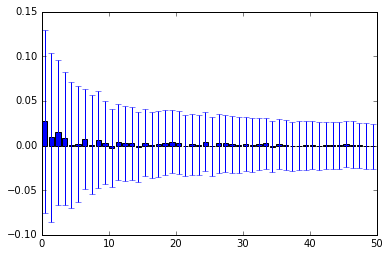

In [718]:
plt.bar(range(50), x_means, yerr=x_stds)